In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Data

In [148]:
homicides = pd.read_csv('~/PUIdata/World firearms murders and ownership - Sheet 1.csv')
homicides = homicides[['Country/Territory', 'Average total all civilian firearms', 'Number of homicides by firearm']]
homicides = homicides.rename(columns={'Country/Territory': 'country',
                                      'Average total all civilian firearms': 'firearms',
                                      'Number of homicides by firearm': 'homicides_firearm'})
homicides.head()

,country,firearms,homicides_firearm
0,Albania,270000.0,56.0
1,Algeria,1900000.0,20.0
2,Angola,2800000.0,NaN
3,Anguilla,NaN,1.0
4,Argentina,3950000.0,1198.0


In [167]:
shootings = requests.get('https://datawrapper.dwcdn.net/pvLFI/6/').text
shootings = shootings.split('data:')[1].split('}')[0].strip()
shootings = shootings.replace('"', '').replace('*','')
shootings = shootings.split('\\n')
shootings = pd.DataFrame(shootings)
shootings[['country', 'sep1', 'data']] = shootings[0].str.partition(',')
shootings[['guns100ppl', 'sep2', 'mass_shootings']] = shootings['data'].str.partition(',')
shootings = shootings.drop(labels=[0, 'sep1','sep2', 'data'], axis=1).drop(0, axis=0)
shootings['guns100ppl'] = shootings['guns100ppl'].astype(float)
shootings['mass_shootings'] = shootings['mass_shootings'].astype(int)
shootings.head()

,country,guns100ppl,mass_shootings
1,Australia,15.0,4
2,Austria,30.4,1
3,Beligium,17.2,2
4,Canada,30.8,4
5,Denmark,12.0,0


In [144]:
pop = pd.read_csv('~/PUIdata/pop/API_SP.POP.TOTL_DS2_en_csv_v2_10203548.csv', header=2)
pop = pop[['Country Name', '2012']]
pop = pop.rename(columns={'Country Name': 'country', '2012': 'pop'})
pop.head()

,country,pop
0,Aruba,102577.0
1,Afghanistan,30696958.0
2,Angola,25096150.0
3,Albania,2900401.0
4,Andorra,82431.0


In [33]:
urllib.request.urlretrieve('http://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=csv', 'gdp.zip')
!mv gdp.zip $PUIDATA
!unzip $PUIDATA/gdp.zip -d $PUIDATA/gdp

Archive:  /nfshome/ak3940/PUIdata/gdp.zip
  inflating: /nfshome/ak3940/PUIdata/gdp/Metadata_Indicator_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10203569.csv  
  inflating: /nfshome/ak3940/PUIdata/gdp/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10203569.csv  
  inflating: /nfshome/ak3940/PUIdata/gdp/Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10203569.csv  


In [146]:
gdp = pd.read_csv('~/PUIdata/gdp/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10203569.csv', header=2)
gdp = gdp[['Country Name', '2012']]
gdp = gdp.rename(columns={'Country Name': 'country', '2012': 'gdp'})
gdp.head()

,country,gdp
0,Aruba,NaN
1,Afghanistan,2.053654e+10
2,Angola,1.139232e+11
3,Albania,1.231978e+10
4,Andorra,3.164615e+09


In [242]:
data = pop.merge(gdp, how='left', on='country').merge(shootings, how='left', on='country').merge(homicides, how='left', on='country')
data = data.dropna().sort_values(by='country').reset_index(drop=True)
data['shootings_pp'] = data['mass_shootings'] / data['pop']
data['firearms_pp'] = data['firearms'] / data['pop']
data['homicides_pp'] = data['homicides_firearm'] / data['pop']
data

,country,pop,gdp,guns100ppl,mass_shootings,firearms,homicides_firearm,shootings_pp,firearms_pp,homicides_pp
0,Australia,22742475.0,1.543411e+12,15.0,4.0,3050000.0,30.0,1.758824e-07,0.134110,1.319118e-06
1,Austria,8429991.0,4.094252e+11,30.4,1.0,2500000.0,18.0,1.186241e-07,0.296560,2.135234e-06
2,Canada,34750545.0,1.824289e+12,30.8,4.0,9950000.0,173.0,1.151061e-07,0.286326,4.978339e-06
3,Denmark,5591572.0,3.271489e+11,12.0,0.0,650000.0,15.0,0.000000e+00,0.116246,2.682609e-06
4,Finland,5413971.0,2.567065e+11,45.3,2.0,2400000.0,24.0,3.694146e-07,0.443298,4.432975e-06
5,France,65659789.0,2.683825e+12,31.2,6.0,19000000.0,35.0,9.138013e-08,0.289370,5.330508e-07
6,Germany,80425823.0,3.543984e+12,30.3,7.0,25000000.0,158.0,8.703672e-08,0.310845,1.964543e-06
7,Greece,11045011.0,2.456707e+11,22.5,0.0,2500000.0,29.0,0.000000e+00,0.226347,2.625620e-06
8,Hungary,9920362.0,1.278566e+11,5.5,0.0,560000.0,7.0,0.000000e+00,0.056450,7.056194e-07
9,Iceland,320716.0,1.429201e+10,30.3,0.0,90000.0,0.0,0.000000e+00,0.280622,0.000000e+00


# Exploration

In [359]:
def err(col):
    error = np.sqrt(col)
    return error

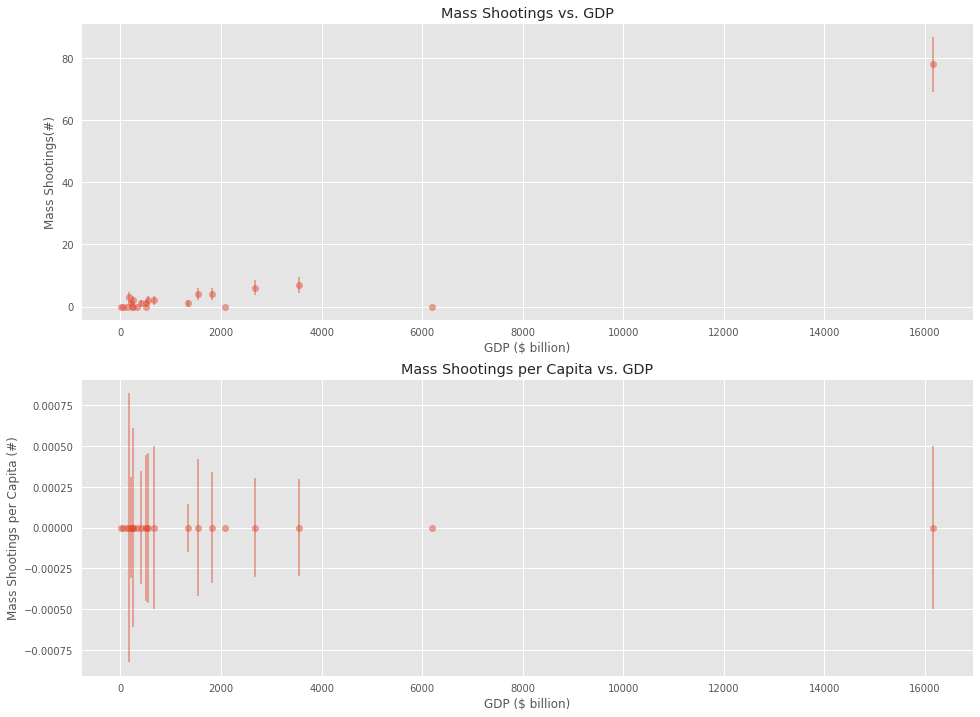

In [373]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.errorbar(data.gdp / 1e9, data.mass_shootings, yerr= err(data['mass_shootings']), marker = 'o', alpha = .5, linestyle='')
ax1.set_xlabel('GDP ($ billion)')
ax1.set_ylabel('Mass Shootings(#)')
ax1.set_title('Mass Shootings vs. GDP')

ax2.errorbar(data.gdp / 1e9, data.shootings_pp, yerr= err(data['shootings_pp']), marker = 'o', alpha = .5, linestyle='')
ax2.set_xlabel('GDP ($ billion)')
ax2.set_ylabel('Mass Shootings per Capita (#)')
ax2.set_title('Mass Shootings per Capita vs. GDP')

plt.show()

## Figure 1: Mass Shootings vs. GDP

*Number of mass shootings in a country plotted against GDP in billion USD. The United States (the outlier located in the top right), stands out in terms of both GDP and number of mass shootings. Gun control remains a highly divisive issue in the United States, where pro-gun-control advocates view easily accessible firearms as a threat to national security, while anti-gun-control advocates believe gun ownership to be an inalieable, constitutional right.*

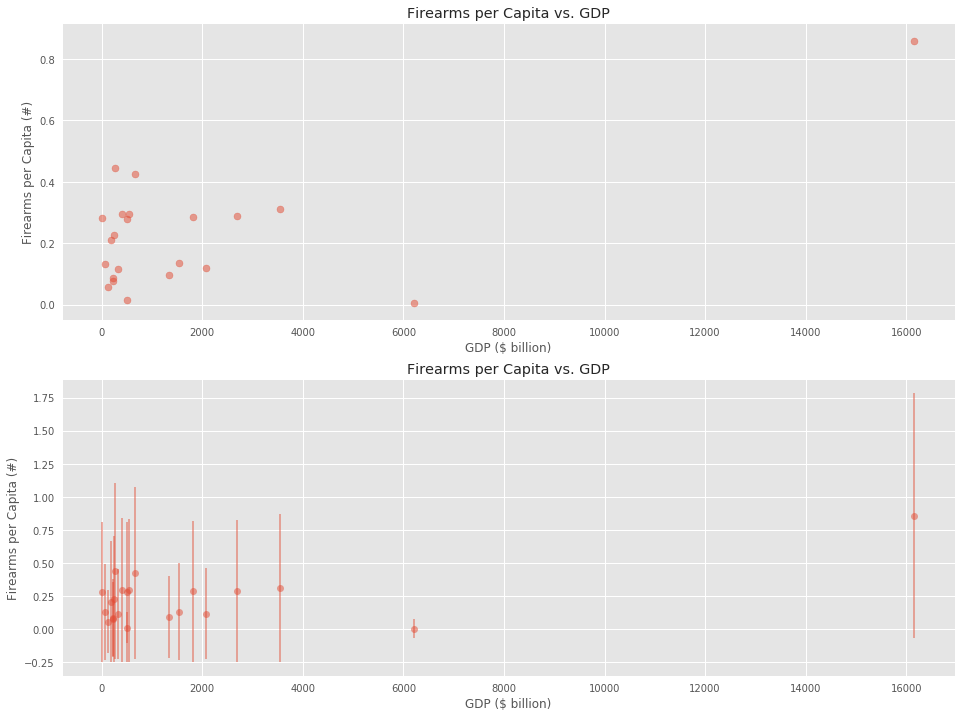

In [369]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.scatter(data.gdp / 1e9, data.firearms_pp, marker = 'o', alpha = .5)
ax1.set_xlabel('GDP ($ billion)')
ax1.set_ylabel('Firearms per Capita (#)')
ax1.set_title('Firearms per Capita vs. GDP')

ax2.errorbar(data.gdp / 1e9, data.firearms_pp, yerr= err(data['firearms_pp']), marker = 'o', alpha = .5, linestyle='')
ax2.set_xlabel('GDP ($ billion)')
ax2.set_ylabel('Firearms per Capita (#)')
ax2.set_title('Firearms per Capita vs. GDP')

plt.show()

## Figure 2: Civilian Firearms per Person vs. GDP
*Unlike in Figure 1, there is much higher variation in the number of civilian firearms per capita than the number of mass shootings per capita. This suggests that gun ownership is not the only determining factor in the number of mass shootings. It is important to note that many countries allow citizens to own firearms, but under strict regulation of when they can use them and where they can keep them. *

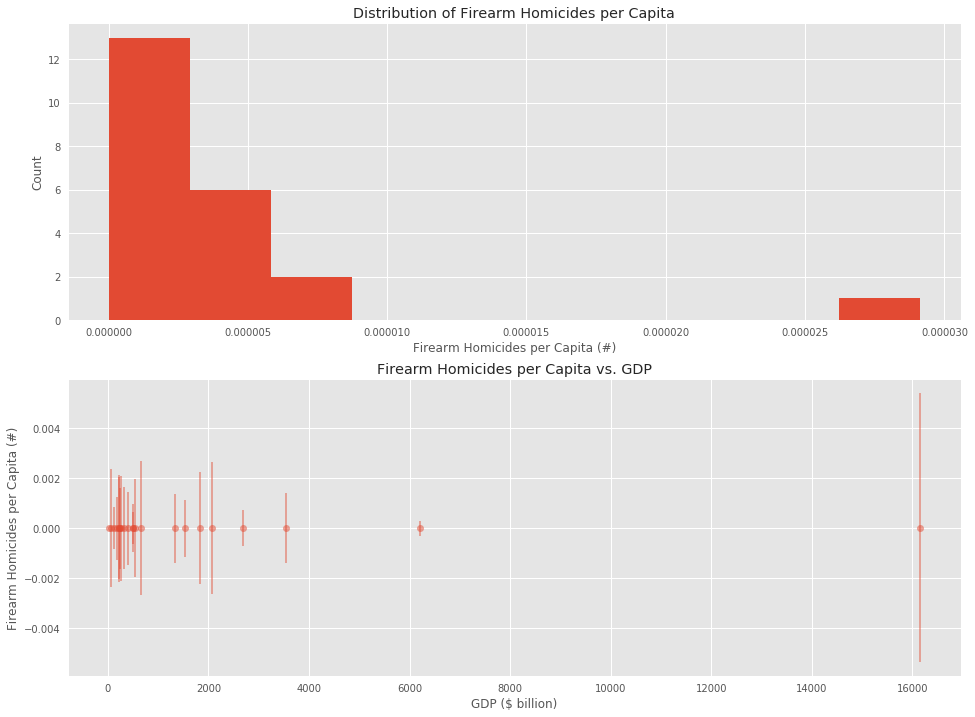

In [374]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.hist(data.homicides_pp)
ax1.set_ylabel('Count')
ax1.set_xlabel('Firearm Homicides per Capita (#)')
ax1.set_title('Distribution of Firearm Homicides per Capita')

ax2.errorbar(data.gdp / 1e9, data.homicides_pp, yerr= err(data['homicides_pp']), marker = 'o', alpha = .5, linestyle='')
ax2.set_xlabel('GDP ($ billion)')
ax2.set_ylabel('Firearm Homicides per Capita (#)')
ax2.set_title('Firearm Homicides per Capita vs. GDP')

plt.show()

## Figure 3: Average Firearm Homicides per Person
*The histogram shows that the majority of countries in the dataset have fewer than 1 homicide per 500,000 people. The United States is a clear outlier with close to 3 homicides per 10,000 people.*

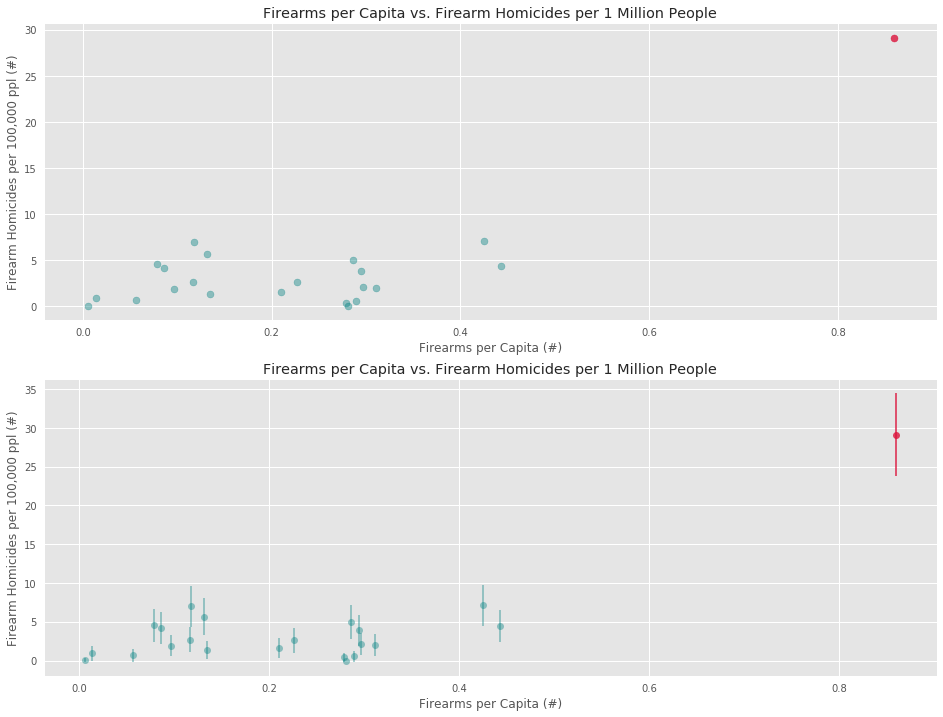

In [389]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.scatter(data[data['country'] != 'United States'].firearms_pp, data[data['country'] != 'United States'].homicides_pp * 1e6, color ='teal', marker = 'o', alpha = .4)
ax1.scatter(data[data['country'] == 'United States'].firearms_pp, data[data['country'] == 'United States'].homicides_pp * 1e6, color = 'crimson', alpha = .8)
ax1.set_xlabel('Firearms per Capita (#)')
ax1.set_ylabel('Firearm Homicides per 100,000 ppl (#)')
ax1.set_title('Firearms per Capita vs. Firearm Homicides per 1 Million People')

ax2.errorbar(data[data['country'] != 'United States'].firearms_pp, data[data['country'] != 'United States'].homicides_pp * 1e6, yerr= np.sqrt(data[data['country'] != 'United States'].homicides_pp * 1e6) , marker = 'o', color = 'teal', alpha = .4, linestyle='')
ax2.errorbar(data[data['country'] == 'United States'].firearms_pp, data[data['country'] == 'United States'].homicides_pp * 1e6, yerr= np.sqrt(data[data['country'] == 'United States'].homicides_pp * 1e6) , marker = 'o', color = 'crimson', alpha = .8, linestyle='')
ax2.set_xlabel('Firearms per Capita (#)')
ax2.set_ylabel('Firearm Homicides per 100,000 ppl (#)')
ax2.set_title('Firearms per Capita vs. Firearm Homicides per 1 Million People')

plt.show()

## Figure 4: Firearm Homicides vs. Civilian Firearms per Person
*Despite some variation among the number of firearms per capita, non-US countries do not exceed 10 firearm homicides per 1 million people. In comparison, the United States comes close to 30 firearm homicides per 1 million people.*

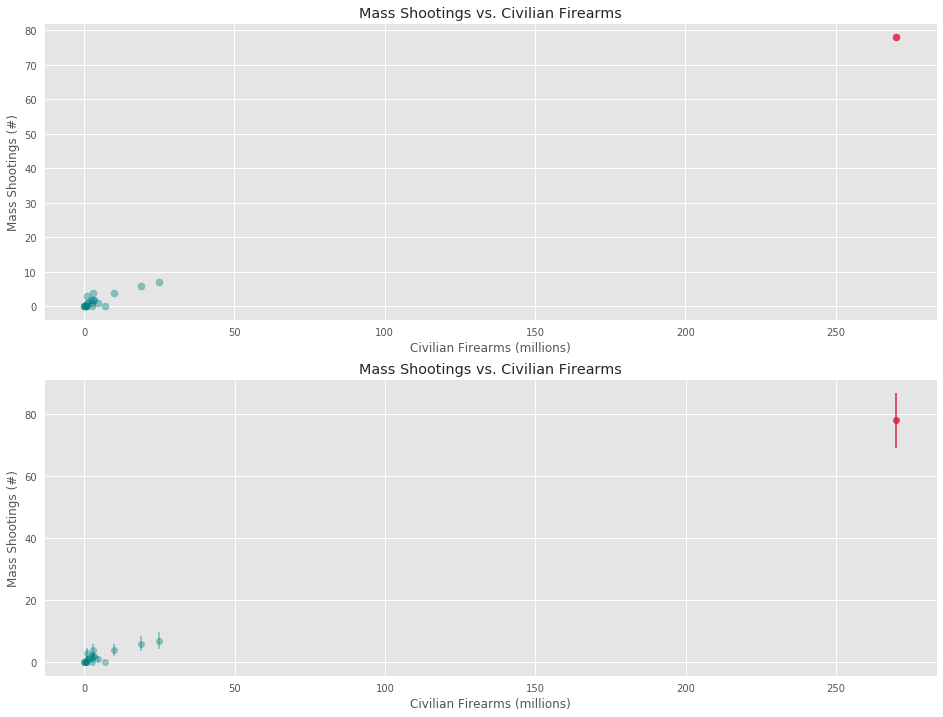

In [394]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.scatter(data[data['country'] != 'United States'].firearms / 1e6, data[data['country'] != 'United States'].mass_shootings, color ='teal', marker = 'o', alpha = .4)
ax1.scatter(data[data['country'] == 'United States'].firearms / 1e6, data[data['country'] == 'United States'].mass_shootings, color = 'crimson', alpha = .8)
ax1.set_xlabel('Civilian Firearms (millions)')
ax1.set_ylabel('Mass Shootings (#)')
ax1.set_title('Mass Shootings vs. Civilian Firearms')

ax2.errorbar(data[data['country'] != 'United States'].firearms / 1e6, data[data['country'] != 'United States'].mass_shootings, yerr= np.sqrt(data[data['country'] != 'United States'].mass_shootings), marker = 'o', color = 'teal', alpha = .4, linestyle='')
ax2.errorbar(data[data['country'] == 'United States'].firearms / 1e6, data[data['country'] == 'United States'].mass_shootings, yerr= np.sqrt(data[data['country'] == 'United States'].mass_shootings), marker = 'o', color = 'crimson', alpha = .8, linestyle='')
ax2.set_xlabel('Civilian Firearms (millions)')
ax2.set_ylabel('Mass Shootings (#)')
ax2.set_title('Mass Shootings vs. Civilian Firearms')

plt.show()

## Figure 5: Mass Shootings vs. Civilian Firearms
*Despite strong clustering of points near the origin, there is still somewhat of a positive linear relationship between the number of civilian firearms and the number of mass shootings. However, it is important to note that these figures are not standardized by population. Nevertheless, similar projections where achieved in previous examples using standardized per-capita meausures.*

# Modeling

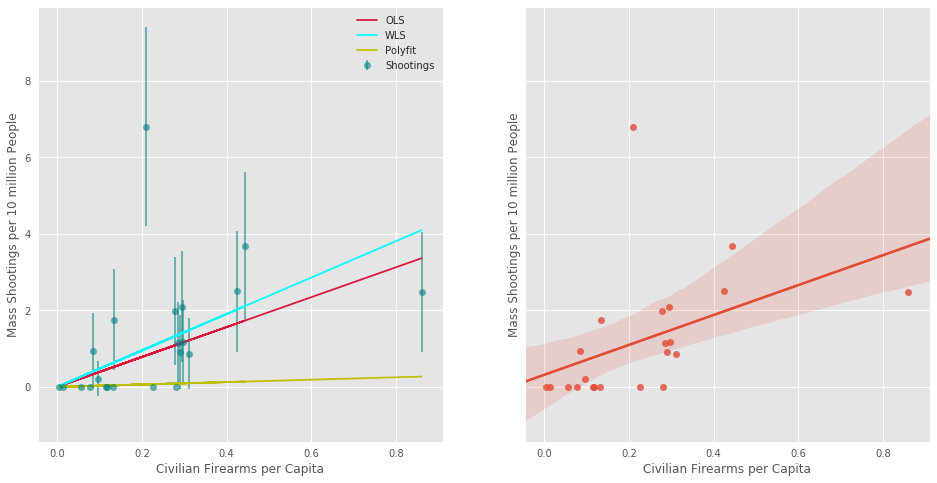

In [472]:
W = 1 / err(data.shootings_pp * 1e7)
W[W > 5] = 0

ols = smf.ols(formula='shootings_pp ~ firearms_pp', data=data).fit()
wls = sm.WLS(data.shootings_pp, data.firearms_pp, weights=W).fit()

polys = np.polyfit(data.firearms_pp, data.shootings_pp * 1e7, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), sharex=True, sharey=True)

ax1.errorbar(data.firearms_pp, data.shootings_pp * 1e7, yerr = err(data.shootings_pp * 1e7), color = 'teal', marker='o', alpha=0.6 , linestyle='', label = 'Shootings')
ax1.plot(data.firearms_pp, ols.params[0] + (ols.params[1] * data.firearms_pp * 1e7), color ='crimson', label = 'OLS')
ax1.plot(data.firearms_pp, wls.params[0] * data.firearms_pp * 1e7, color = 'cyan', label = 'WLS')
ax1.plot(data.firearms_pp, polys[1] * data.firearms_pp, 'y', label='Polyfit')

ax2 = sns.regplot(x=data.firearms_pp, y=data.shootings_pp * 1e7)

ax1.set_xlabel('Civilian Firearms per Capita')
ax1.set_ylabel('Mass Shootings per 10 million People')
ax2.set_xlabel('Civilian Firearms per Capita')
ax2.set_ylabel('Mass Shootings per 10 million People')

ax1.legend()
plt.show()

## Figure 6: Fitting Mass Shootings vs. Civilian Firearms per Capita using Multiple Methods

*Using lines with different fits show how various models differ with respect to their sensivity to outliers. Based on the plots above, it appears that either WLS or seaborn's regplot produce the best fit.*